In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

D:\Anaconda\envs\tensor14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\tensor14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\tensor14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\tensor14\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

1 Physical GPUs, 1 Logical GPUs


In [6]:
import pickle
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

with open('data.pickle','rb') as f:
    data=pickle.load(f)

def deaccu_year(data):
    def deaccu(dat):
        for i in range(-1,-len(dat),-1):
            dat[i]=dat[i]-dat[i-1]
        return dat
    
    for i in range(8):
        data[i*12:i*12+12]=deaccu(data[i*12:i*12+12])
    return data

def data_generator(data,label, batch,window=6, forward=1, stride=1):
    def sort_months(months):
        result=[]
        for index,row in months.iterrows():
            result.append(list(row))
        return result
    x,s,c=[],[],[]
    X, Y = [], []
    counter=0
    i=0
    while(1):
        if i>len(data) - window-1:
            i=0
        x.append(np.array( sort_months(data[i:(i + window)].astype('float')) ))
        s.append(np.zeros((100)))
        c.append(np.zeros((100)))

        Y.append(np.expand_dims(label[(i + window):(i + window + forward)],axis=1))

        i=i+stride
        if counter ==batch-1:
            counter=0
            X=([x,s,c])
            yield X,np.array(Y).astype('float')
            X, Y = [], []
            x,s,c=[],[],[]
        else:
            counter=counter+1

In [7]:
from sklearn import preprocessing
# 计算y
price=deaccu_year(data['sqr quant'])
for i in range(8):
    price[i*12+1]=price[i*12]
square=deaccu_year(data['sqr sum'])
for i in range(8):
    square[i*12+1]=square[i*12]
label=(price/square)*10000

# 标准化
label=preprocessing.scale(label)
for i in data.columns:
    data[i]=preprocessing.scale(data[i])

In [4]:
# import numpy as np

# def data_generator(data,label, batch,window=6, forward=1, stride=1):
#     def sort_months(months):
#         result=[]
#         for index,row in months.iterrows():
#             result.append(list(row))
# #         print(months.index)
#         return result
    
#     X, Y = [], []
#     counter=0
#     i=0
#     while(1):
#         if i>len(data) - window-1:
#             i=0
        
#         X.append(sort_months(data[i:(i + window)]))
        
# #         X.append(([label[(i + window-forward):(i + window )]]))
#         Y.append((label[(i + window):(i + window + forward)]))
# #         Y.append((label[(i + window-forward):(i + window )]))
#         i=i+stride
#         if counter ==batch-1:
#             counter=0
# #             try:
#             yield np.array(X).astype('float'),np.array(Y).astype('float')
# #             except:
# #                 print(X)
# #                 print(Y)
#             X, Y = [], []
#         else:
#             counter=counter+1

In [5]:
# window=6
# batch=1
# forward=3
# stride=3
# # new=data
# new=data.drop(['sqr quant','sqr sum'],axis=1)
# train_generator=data_generator(new[0:60],label,batch=batch, window=window, forward=forward, stride=stride)
# test_generator=data_generator(new[60:96],label,batch=batch, window=window, forward=forward, stride=stride)

In [8]:
import math
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Activation, TimeDistributed, Dropout, Lambda, RepeatVector, Input, Reshape, Concatenate, Dot
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')
def one_step_attention(a, s_prev, repeator, concatenator, densor, activator, dotor):
    s_prev = repeator(s_prev)
    concat = concatenator([s_prev, a])
    e = densor(concat)
    alphas = activator(e)
    context =  dotor([alphas, a])
    return context
def seq2seq_attention(feature_len=1, after_day=1, input_shape=(20, 1), time_step=20):
    # Define the inputs of your model with a shape (Tx, feature)
    X = Input(shape=input_shape)
    s0 = Input(shape=(100, ), name='s0')
    c0 = Input(shape=(100, ), name='c0')
    s = s0
    c = c0

    # Initialize empty list of outputs
    all_outputs = []

    # Encoder: pre-attention LSTM
    encoder_outputs = LSTM(units=100, return_state=False, return_sequences=True, name='encoder')(X)
    # Decoder: post-attention LSTM
    decoder = LSTM(units=100, return_state=True, name='decoder')
    # Output
    decoder_output = Dense(units=1, activation='linear', name='output')
    model_output = Reshape((1, 1))

    # Attention
    repeator = RepeatVector(time_step)
    concatenator = Concatenate(axis=-1)
    densor = Dense(1, activation = "relu")
    activator = Activation(softmax, name='attention_weights')
    dotor =  Dot(axes = 1)

    for t in range(after_day):
        context = one_step_attention(encoder_outputs, s, repeator, concatenator, densor, activator, dotor)

        a, s, c = decoder(context, initial_state=[s, c])

        outputs = decoder_output(a)
        outputs = model_output(outputs)
        all_outputs.append(outputs)

    all_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(inputs=[X, s0, c0], outputs=all_outputs)
    return model

In [9]:
window=6
batch=3
forward=3
stride=3
split=60
new=data.drop(['sqr quant','sqr sum'],axis=1)
train_generator=data_generator(new[split:],label[split:],batch=batch, window=window, forward=forward, stride=stride)
test_generator=data_generator(new[:split],label[:split],batch=batch, window=window, forward=forward, stride=stride)
total_generator=data_generator(new[:],label,batch=batch, window=window, forward=forward, stride=stride)
# train_generator=data_generator(new[:split],label[:split],batch=batch, window=window, forward=forward, stride=stride)
# test_generator=data_generator(new[split:],label[split:],batch=batch, window=window, forward=forward, stride=stride)
# total_generator=data_generator(new[:],label,batch=batch, window=window, forward=forward, stride=stride)

In [6]:
from tensorflow.keras.layers import Dense, Input,LSTM,Conv1D,GlobalMaxPool1D,Masking
from tensorflow.keras.layers import  Embedding, Dropout,Bidirectional,Concatenate,TimeDistributed
from tensorflow.keras.models import Model
from imp import reload
window=6
batch=2
forward=3
stride=3

input_shape = (window,len(new.iloc[1]))
model = seq2seq_attention(len(new), forward, input_shape, window)
model.compile(loss='mean_squared_error', optimizer='adam')

W0213 22:10:05.806153  5160 deprecation.py:506] From D:\Anaconda\envs\tensor14\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
import datetime
import os
mod_path='./seq2seq/mod/20200212_48before/'
if not os.path.exists(mod_path):
    os.makedirs(mod_path)
checkpointer = ModelCheckpoint(filepath=mod_path+"weights-{epoch:02d}-{val_loss:.2f}.hdf5",
                               monitor='val_loss',mode='max',verbose=1, save_best_only=False,save_weights_only=True)
log_dir=r"./seq2seq/log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit_generator(train_generator,epochs=24,                    
                    workers=1,callbacks=[checkpointer,tensorboard_callback], 
                    validation_data=test_generator,
                    validation_steps=10,
                    steps_per_epoch= (len(data) - window)/(batch*stride),
                    use_multiprocessing=False, 
                    shuffle=False)

W0212 22:54:12.172579 12072 deprecation.py:323] From D:\Anaconda\envs\tensor14\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/24
 1/15 [=>............................] - ETA: 50s - loss: 0.1206

W0212 22:54:15.846298 12072 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.131508). Check your callbacks.



 2/15 [===>..........................] - ETA: 24s - loss: 0.1028

W0212 22:54:15.870262 12072 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.115313). Check your callbacks.


14/15 [===========================>..] - ETA: 0s - loss: 0.4796
Epoch 00001: saving model to ./HousePrice/seq2seq\mod\20200212_48before\weights-01-0.38.hdf5
15/15 [==============================] - 5s 307ms/step - loss: 0.4521 - val_loss: 0.3844
Epoch 2/24
13/15 [=========================>....] - ETA: 0s - loss: 0.1029
Epoch 00002: saving model to ./HousePrice/seq2seq\mod\20200212_48before\weights-02-0.44.hdf5
15/15 [==============================] - 1s 36ms/step - loss: 0.0931 - val_loss: 0.4362
Epoch 3/24
13/15 [=========================>....] - ETA: 0s - loss: 0.0386
Epoch 00003: saving model to ./HousePrice/seq2seq\mod\20200212_48before\weights-03-0.50.hdf5
15/15 [==============================] - 1s 35ms/step - loss: 0.0351 - val_loss: 0.5005
Epoch 4/24
13/15 [=========================>....] - ETA: 0s - loss: 0.0155
Epoch 00004: saving model to ./HousePrice/seq2seq\mod\20200212_48before\weights-04-0.48.hdf5
15/15 [==============================] - 1s 34ms/step - loss: 0.0149 - val

KeyboardInterrupt: 

In [7]:
# del model
model.load_weights('./seq2seq/mod/20200212/weights-24-1.36.hdf5')

In [48]:
from tensorflow.keras.models import Sequential, load_model, Model
visu=Model(inputs=model.inputs,outputs=model.layers[6].output)

Text(0, 0.5, 'trend')

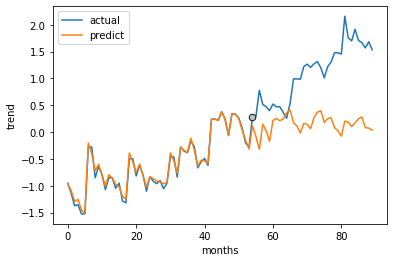

In [49]:
import  matplotlib.pyplot as plt
plt.cla()
actual=[]
predict=[]
activation=np.array([])
split=60
# train_generator=data_generator(new[split:],label[split:],batch=batch, window=window, forward=forward, stride=stride)
# test_generator=data_generator(new[:split],label[:split],batch=batch, window=window, forward=forward, stride=stride)
# total_generator=data_generator(new[:],label,batch=batch, window=window, forward=forward, stride=stride)
train_generator=data_generator(new[:split],label[:split],batch=batch, window=window, forward=forward, stride=stride)
test_generator=data_generator(new[split:],label[split:],batch=batch, window=window, forward=forward, stride=stride)
total_generator=data_generator(new[:],label,batch=batch, window=window, forward=forward, stride=stride)

for k in range(int(90/(stride*batch))+1):
    x,y=total_generator.__next__()
#     print(x)
#     print('-------------------')
#     print(y)
#     print('==================================')
    actual=actual+y[:].reshape(-1).tolist()
    predict=predict+model.predict(x)[:].reshape(-1).tolist()
    for index,i in enumerate(visu.predict(x)):
        if len(activation)==0:
            activation=i.reshape(-1)
#             print(activation.shape)
        else:
            activation[-3:]=activation[-3:]+i.reshape(-1)[:3]
            activation=np.append(activation,i.reshape(-1)[-3:])
plt.plot(actual[0:90])
plt.plot(predict[0:90])
plt.plot(split-6, actual[split-6], color = '0.9', linewidth=1,
               markersize = 13, marker='.',
               markeredgecolor = '0.10', markerfacecolor = '0.75')
plt.legend(["actual","predict"])
plt.xlabel('months')
plt.ylabel('trend')

In [50]:
bar=[list(activation[0:90])]
for i in range(9):
    bar.append(list(activation[0:90]))
bar=np.array(bar)
plt.imshow(bar)

(10, 90)